In [1]:
import uproot
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import awkward as ak
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
file = uproot.open("tracking_losses_ntuple_Bd2KstEE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")



#selektiere Kaonen und Pionen aus K*->Kpi - B->K*ee - und nur solche mit einem momentum von ueber 5 GeV 
allcolumns = file.arrays()
found = allcolumns[((allcolumns.isPion) | (allcolumns.isKaon)) & (~allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p>5e3)] #B: 8126
lost = allcolumns[((allcolumns.isPion) | (allcolumns.isKaon)) & (allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p>5e3)] #B: 410

ak.num(lost, axis=0)
#ak.count(found, axis=None)


410

In [3]:
def t_eff(found, lost):
    sel = found["energy"]
    des = lost["energy"]
    return ak.count(sel,axis=None)/(ak.count(sel,axis=None)+ak.count(des,axis=None))

t_eff(found, lost)


0.9519681349578257

In [4]:
#ist die shape der teilspur im scifi anders? (koenntest du zum beispiel durch vergleich der verteilungen der fit parameter studieren,
#in meiner thesis findest du das fitmodell -- ist einfach ein polynom dritten grades)
z_ref=8520 #mm

def scifi_track(z, a, b, c, d):
    return a + b*(z-z_ref) + c*(z-z_ref)**2 + d*(z-z_ref)**3

def z_mag(xv, zv, tx, a, b):
    """ optical centre of the magnet is defined as the intersection between the trajectory tangents before and after the magnet

    Args:
        xv (double): velo x track
        zv (double): velo z track
        tx (double): velo x slope
        a (double): ax parameter of track fit
        b (double): bx parameter of track fit

    Returns:
        double: z_mag
    """
    return (xv-tx*zv-a+b*z_ref)/(b-tx)

In [5]:
scifi_found = found[found["scifi_hit_pos_x_length"]>3]
scifi_lost = lost[lost["scifi_hit_pos_x_length"]>3]

scifi_x_found = scifi_found["scifi_hit_pos_x"]
scifi_z_found = scifi_found["scifi_hit_pos_z"]

tx_found = scifi_found["velo_track_tx"]

scifi_x_lost = scifi_lost["scifi_hit_pos_x"]
scifi_z_lost = scifi_lost["scifi_hit_pos_z"]

tx_lost = scifi_lost["velo_track_tx"]

xv_found = scifi_found["velo_track_x"]
zv_found = scifi_found["velo_track_z"]

xv_lost = scifi_lost["velo_track_x"]
zv_lost = scifi_lost["velo_track_z"]



#ak.num(scifi_found["energy"], axis=0)
#scifi_found.snapshot()

In [6]:
scifi_fitpars_found = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]))
    scifi_fitpars_found.begin_list()
    scifi_fitpars_found.real(popt[0])
    scifi_fitpars_found.real(popt[1])
    scifi_fitpars_found.real(popt[2])
    scifi_fitpars_found.real(popt[3])
    scifi_fitpars_found.end_list()

scifi_fitpars_lost = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]))
    scifi_fitpars_lost.begin_list()
    scifi_fitpars_lost.real(popt[0])
    scifi_fitpars_lost.real(popt[1])
    scifi_fitpars_lost.real(popt[2])
    scifi_fitpars_lost.real(popt[3])
    scifi_fitpars_lost.end_list()


scifi_fitpars_lost = scifi_fitpars_lost.to_numpy()
scifi_fitpars_found = scifi_fitpars_found.to_numpy()


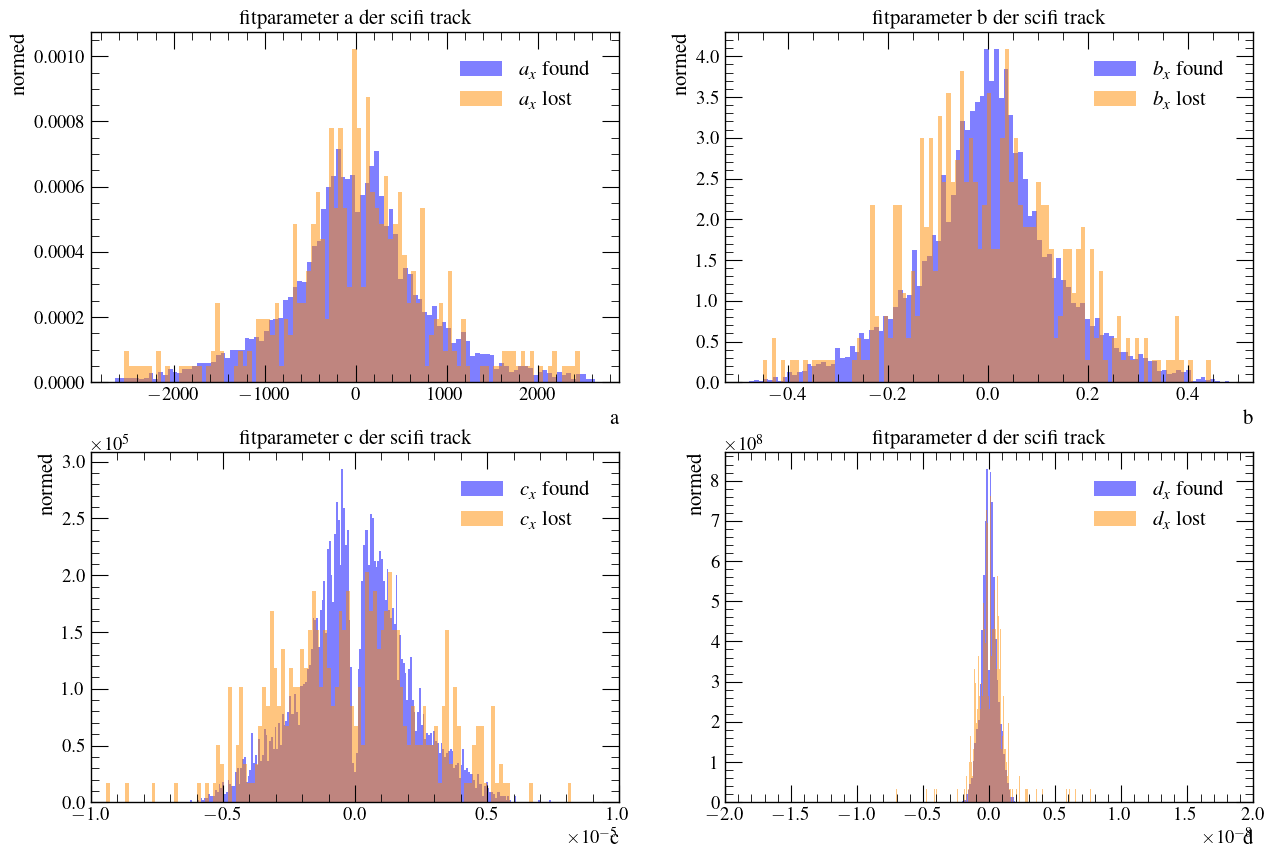

In [7]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax0.hist(scifi_fitpars_found[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$a_x$ found")
ax0.hist(scifi_fitpars_lost[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$a_x$ lost")
ax0.set_xlabel("a")
ax0.set_ylabel("normed")
ax0.set_title("fitparameter a der scifi track")
ax0.legend()

ax1.hist(scifi_fitpars_found[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$b_x$ found")
ax1.hist(scifi_fitpars_lost[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$b_x$ lost")
ax1.set_xlabel("b")
ax1.set_ylabel("normed")
ax1.set_title("fitparameter b der scifi track")
ax1.legend()

ax2.hist(scifi_fitpars_found[:,2], bins=200, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$c_x$ found")
ax2.hist(scifi_fitpars_lost[:,2], bins=200, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$c_x$ lost")
ax2.set_xlim([-1e-5,1e-5])
ax2.set_xticks(np.arange(-1e-5,1.5e-5,5e-6),minor=False)
ax2.set_xlabel("c")
ax2.set_ylabel("normed")
ax2.set_title("fitparameter c der scifi track")
ax2.legend()

ax3.hist(scifi_fitpars_found[:,3], bins=200, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$d_x$ found")
ax3.hist(scifi_fitpars_lost[:,3], bins=200, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$d_x$ lost")
ax3.set(xlim=(-2e-8,2e-8))
ax3.set_xlabel("d")
ax3.set_ylabel("normed")
ax3.set_title("fitparameter d der scifi track")
ax3.legend()

"""
a_x: virtual hit on the reference plane
"""

plt.show()

In [8]:
"""
Electrons
found
a =  -0.6718207391527037    b =  0.0013778237292529144      c =  3.3126998287416195e-08     d =  -1.0330674442255529e-10
lost
a =  -36.98764338200992     b =  -0.015685137956233643      c =  -8.265859479503501e-07     d =  -1.541510766903436e-11

Kaon and Pions
found
a =  1.3758753561567658     b =  1.4867317350363123e-05     c =  1.0611928711675984e-09     d =  2.524323901023556e-12
lost
a =  19.655460959039587     b =  -0.0007972008149349264     c =  -1.6113881305735422e-07    d =  8.074893917737833e-11

Kaons
found
a =  1.553371699292705		b =  8.625619976952656e-05		c =  3.1024420569192613e-09		d =  -2.028183118694356e-13
lost
a =  50.918713410777336		b =  0.005102900113795297		c =  -7.416239379215659e-09		d =  5.64633728533602e-11

Pions
found
a =  1.1512709788236055		b =  -7.54683774644083e-05		c =  -1.5218096529826036e-09		d =  5.975257412125118e-12
lost
a =  -3.625684483743866		b =  -0.005190892995904242		c =  -2.7561307005171267e-07		d =  9.883393537611524e-11
"""

print("found")
print("a = ", str(np.mean(scifi_fitpars_found[:,0])))
print("b = ", str(np.mean(scifi_fitpars_found[:,1])))
print("c = ", str(np.mean(scifi_fitpars_found[:,2])))
print("d = ", str(np.mean(scifi_fitpars_found[:,3])))

print("lost")
print("a = ", str(np.mean(scifi_fitpars_lost[:,0])))
print("b = ", str(np.mean(scifi_fitpars_lost[:,1])))
print("c = ", str(np.mean(scifi_fitpars_lost[:,2])))
print("d = ", str(np.mean(scifi_fitpars_lost[:,3])))


found
a =  1.3758753561567658
b =  1.4867317350363123e-05
c =  1.0611928711675984e-09
d =  2.524323901023556e-12
lost
a =  19.655460959039587
b =  -0.0007972008149349264
c =  -1.6113881305735422e-07
d =  8.074893917737833e-11


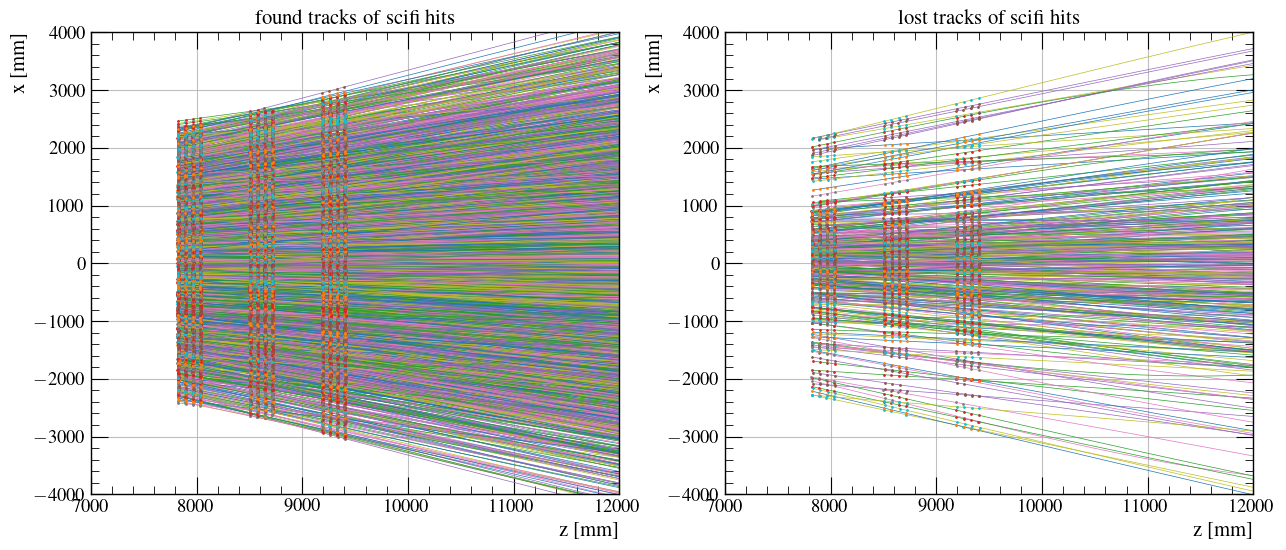

In [9]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_found[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_found[i])
    ax0.plot(z_coord, fit, "-", lw=0.5)
    ax0.errorbar(ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]),fmt=".",ms=2)

#ax0.legend()
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title("found tracks of scifi hits")
ax0.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax0.grid()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_lost[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_lost[i])
    ax1.plot(z_coord, fit, "-", lw=0.5)
    ax1.errorbar(ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]),fmt=".",ms=2)

#ax1.legend()
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title("lost tracks of scifi hits")
ax1.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax1.grid()

plt.show()

In [10]:
#vergleich der zmag werte
zmag_found = z_mag(xv_found, zv_found, tx_found, scifi_fitpars_found[:,0], scifi_fitpars_found[:,1])
zmag_lost = z_mag(xv_lost, zv_lost, tx_lost, scifi_fitpars_lost[:,0], scifi_fitpars_lost[:,1])
zmag_lost = zmag_lost[~np.isnan(zmag_lost)]
zmag_found = zmag_found[~np.isnan(zmag_found)]

print("found \nzmag = ", str(np.mean(zmag_found)))
print("lost \nzmag = ", str(np.mean(zmag_lost)))

found 
zmag =  5196.312017664934
lost 
zmag =  5200.71031871899


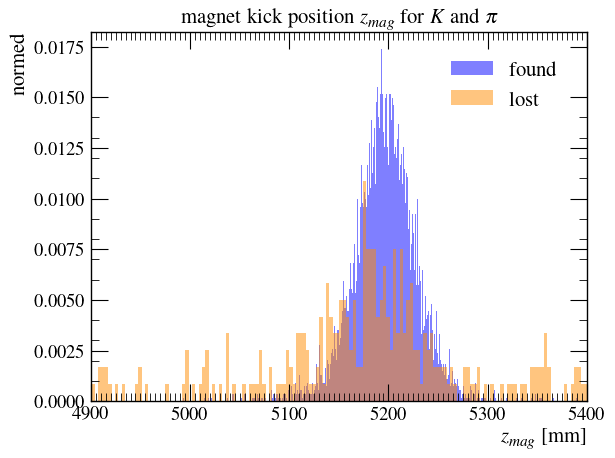

In [11]:
plt.hist(zmag_found, bins=2000, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.hist(zmag_lost, bins=500, density=True, alpha=0.5, histtype="bar",color="darkorange", label="lost")
plt.xlabel("$z_{mag}$ [mm]")
plt.ylabel("normed")
plt.title("magnet kick position $z_{mag}$ for $K$ and $\pi$")
plt.legend()
plt.xticks(np.arange(4900,5405,5), minor=True)
plt.yticks(np.arange(0,0.015,0.001), minor=True)
plt.xlim(4900,5400)

"""
the distribution for lost K and pi has a peak at around the same zmag value as found but its less compact and seems chaotic outside the range of the peak.
the distribution for found particles appears compact around the peak.

"""

plt.show()